# **Sales Price Study Notebook**

## Objectives

* Answer the first business requirement:
    * Enable the customer to visualize which features of the dataset are most closely correlated to the property price.
        
## Inputs
        
* outputs/datasets/collection/HousePricesData.csv

        
## Outputs
        
* Generate code that answers business requirement 1 and can be used to build the Streamlit App.

## Additional comments

* We will be applying the methodology described in https://github.com/Code-Institute-Solutions/churnometer/blob/main/jupyter_notebooks/02%20-%20Churned%20Customer%20Study.ipynb, adapting it to our database and business requirements.
        

---

## Change working directory

* We use os.getcwd() to access the current directory.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/P5-heritage-housing-issues/jupyter_notebooks'

## Access the parent directory
* We want to make the parent of the current directory the new current directory.
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


## Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/P5-heritage-housing-issues'

---

## Load data

* Import the pandas library
* Load the dataset as a pandas DataFrame and assign it to our dataframe df_prices
* View the data in the df_prices variable

In [4]:
import pandas as pd
df_prices = (pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv"))
df_prices.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.869214,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


## Data Exploration

* We want to get more familiar with the dataset, check the variables. Determine their type, distribution and missing levels. We will use this exploration to create an image of what these variables mean in our project's context.
* We will use Panda's Profile Report (https://github.com/ydataai/ydata-profiling/blob/develop/README.md) to get an analysis of each of our variables, see the missing data levels, range and so on.
    * We notice there are 20 numerical and 4 categorical variables.

In [ ]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df_prices, minimal=True)
pandas_report.to_notebook_iframe()

## Correlation Study

* We will use Pearson's and Sperman's correlation tests. As both only consider numerical variables, we will use OneHotEncoder totransform the categorical data. The documentation can be found here https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* We use OneHotEncoder to replace the categorical variables with a combination of binary variables (which takes value 0 or 1) where each new binary variable is related to a label from the categorical variable.

In [7]:
from feature_engine.encoding import OneHotEncoder
encoder = OneHotEncoder(variables=df_prices.columns[df_prices.dtypes=='object'].to_list(), drop_last=False)
df_ohe = encoder.fit_transform(df_prices)
print(df_ohe.shape)
df_ohe.head(3)

(1460, 38)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GarageYrBlt,GrLivArea,LotArea,LotFrontage,...,BsmtFinType1_BLQ,BsmtFinType1_LwQ,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_None,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex,KitchenQual_Fa
0,856,854.0,3.0,706,150,548,2003.0,1710,8450,65.0,...,0,0,1,0,0,0,1,0,0,0
1,1262,0.0,3.0,978,284,460,1976.0,1262,9600,80.0,...,0,0,1,0,0,0,0,1,0,0
2,920,866.0,3.0,486,434,608,2001.0,1786,11250,68.0,...,0,0,1,0,0,0,1,0,0,0


* We will create a few functions to help us in our correlation analysis.

In [42]:
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def heatmap_correlation(df, threshold, title, figsize=(20,12), annot_size = 8):
  """
  Function to create heatmap using Pearson's and Spearman's correlations.
  """
  if len(df.columns) > 1:
    # we create the mask for the upper diagonal and
    # show only values greater than the threshold
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    # we plot the heatmap
    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(data=df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": annot_size},
                ax=axes, linewidth=0.5).set(title=title)
    plt.ylim(len(df.columns),0)

def calculate_correlation(df):
  """
  Function to calculate correlations.
  """
  df_corr_spearman = df.corr(method="spearman")
  df_corr_spearman.name = 'corr_spearman'
  df_corr_pearson = df.corr(method="pearson")
  df_corr_pearson.name = 'corr_pearson'

  return df_corr_pearson, df_corr_spearman

def display_correlation(df_corr_pearson, df_corr_spearman, CorrThreshold,
                      figsize=(20,12), annot_size=8):
  """
  Function to display the correlations.
  """

  print("\n")
  heatmap_correlation(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, annot_size=annot_size,
                      title="*** Heatmap: Spearman Correlation *** \n Evaluates monotonic relationship")

  print("\n")
  heatmap_correlation(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, annot_size=annot_size,
                      title="*** Heatmap: Pearson Correlation *** \n Evaluates the linear relationship")

In [43]:
df_corr_pearson, df_corr_spearman = calculate_correlation(df_prices)




*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



NameError: name 'data' is not defined

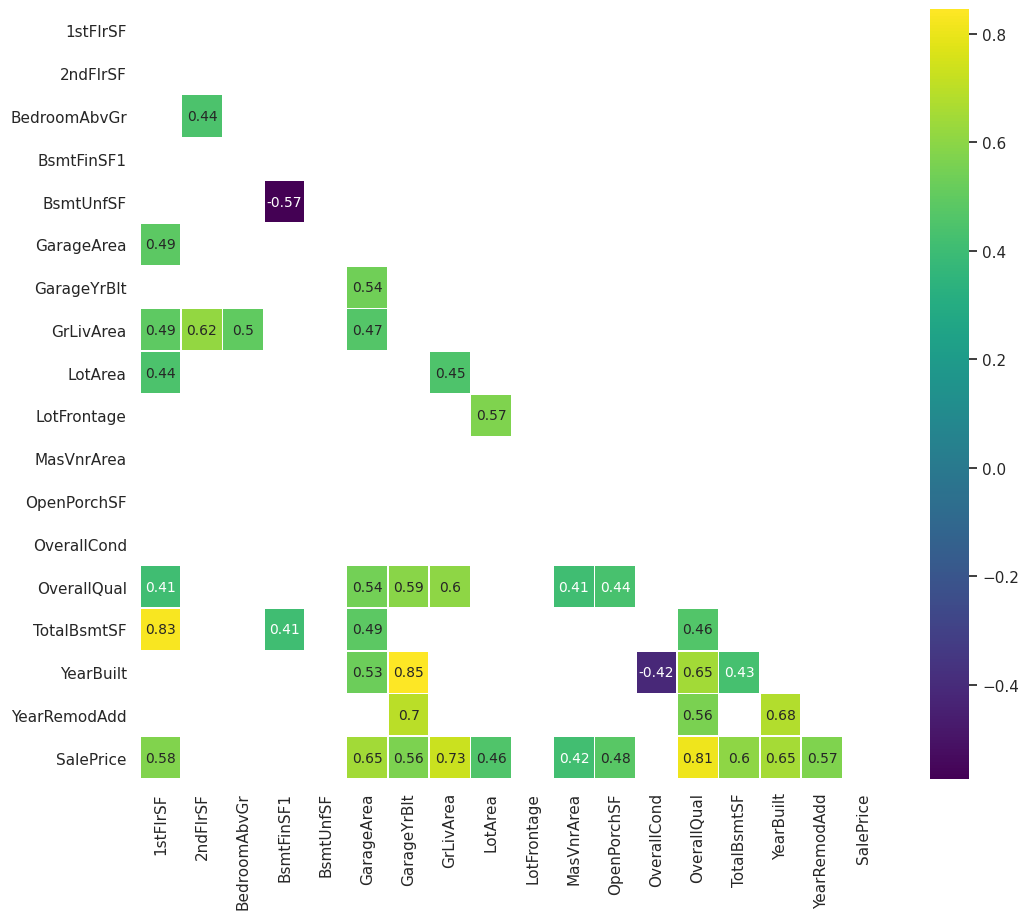

In [44]:
display_correlation(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  CorrThreshold = 0.4,
                  figsize=(20,12), annot_size=10)

* In this dataset, the target variable is SalePrice, so only look at correlations with SalePrice, and sort values by their absolute value, using .sort_values(key=abs, ascending=False). We know the first value will be the target variable itself, so we eliminate it by starting at the second position with [1:]. We will be looking at the top 15 correlations in this study.
* We show the top fifteen values for spearman and top twelve for pearson.

In [ ]:
corr_spearman = df_ohe.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(15)
corr_spearman

In [ ]:
corr_pearson = df_ohe.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(12)
corr_pearson

We merge both correlations and avoid duplications by using set()

In [ ]:
top_n = 15
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

* We create a list of our top 15 most influential variables for further study.

In [ ]:
vars_to_study = [ , ] 
vars_to_study